In [114]:
import matplotlib.pyplot as plt
import numpy as np # untuk visualisasi
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator # untuk membuat data bervariasi
from tqdm import tqdm
import os
import cv2
from sklearn.utils import shuffle # untuk mengacak data
from sklearn.model_selection import train_test_split #untuk membaca training dan testing
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import os
from PIL import Image
from warnings import filterwarnings
for dirname, _, filenames in os.walk('datasets'): #membaca content yang ada di datasets
  for filename in filenames:
    os.path.join(dirname, filename)

In [115]:
#memberikan label penyakit kanker kulit
labels = ['Basal Cell Carcinoma','Melanoma','Seborrheic Keratosis', 'Skin Normal']

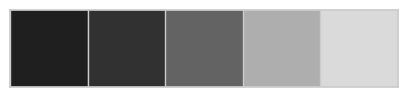

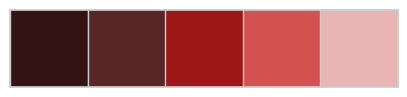

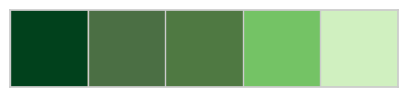

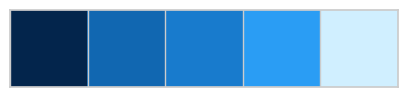

In [116]:
#mendelekarasikan warna grafik
colors_dark = ['#1F1F1F', '#313131', '#636363', '#AEAEAE', '#DADADA']
colors_red = ['#331313', '#582626', '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C', '#4B6F44', '#4F7942', '#74C365', '#D0F0C0']
colors_blue = ['#03254C', '#1167B1', '#187BCD', '#2A9DF4', '#D0EFFf']

sns.palplot(colors_dark)
sns.palplot(colors_red)
sns.palplot(colors_green)
sns.palplot(colors_blue)

In [117]:
x_train = []
y_train = []
image_size = 150 # merisize gambar menjadi 150x150
#membagi datasets training dan testing dengan masing-masing label
for i in labels:
  folderPath = os.path.join('datasets','Training',i)
  for j in tqdm(os.listdir(folderPath)):
    img = cv2.imread(os.path.join(folderPath,j))
    img = cv2.resize(img,(image_size, image_size))
    x_train.append(img)
    y_train.append(i)

  for i in labels:
      folderPath = os.path.join('datasets','Testing',i)
  for j in tqdm(os.listdir(folderPath)):
    img = cv2.imread(os.path.join(folderPath,j))
    img = cv2.resize(img,(image_size, image_size))
    x_train.append(img)
    y_train.append(i)

x_train = np.array(x_train)
y_train = np.array(y_train)
#sehingga masing masing label memiliki 2 data jadi ada 8

100%|██████████| 19/19 [00:00<00:00, 39.41it/s]


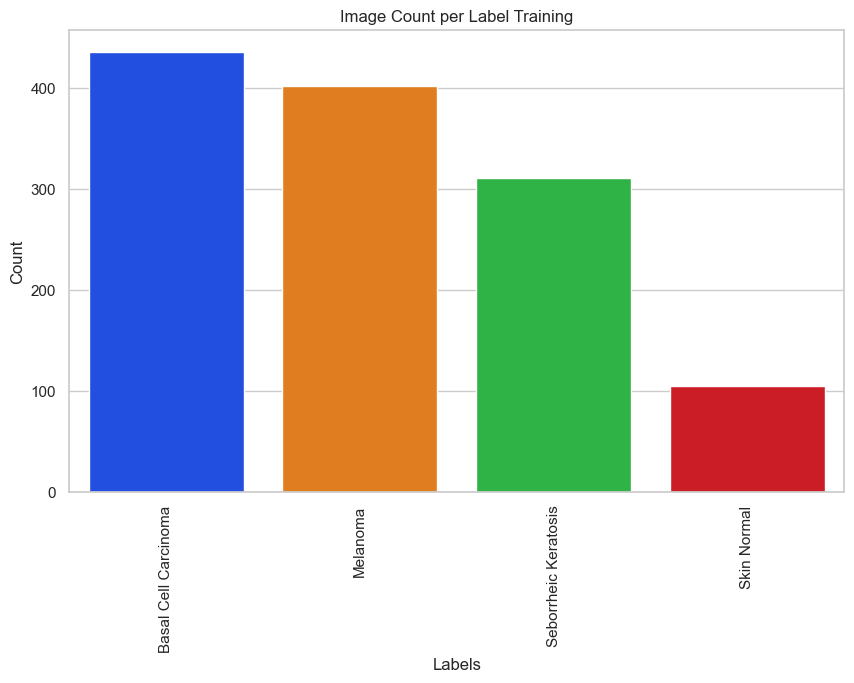

In [118]:
data_folder = 'datasets/Training'


label_dirs = [d for d in os.listdir(data_folder) if os.path.isdir(os.path.join(data_folder, d))]

label_counts = {}
for label_dir in label_dirs:
    label_path = os.path.join(data_folder, label_dir)
    file_count = len([f for f in os.listdir(label_path) if os.path.isfile(os.path.join(label_path, f))])
    label_counts[label_dir] = file_count


sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()), palette="bright")

plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Image Count per Label Training')
plt.xticks(rotation='vertical')
plt.show()

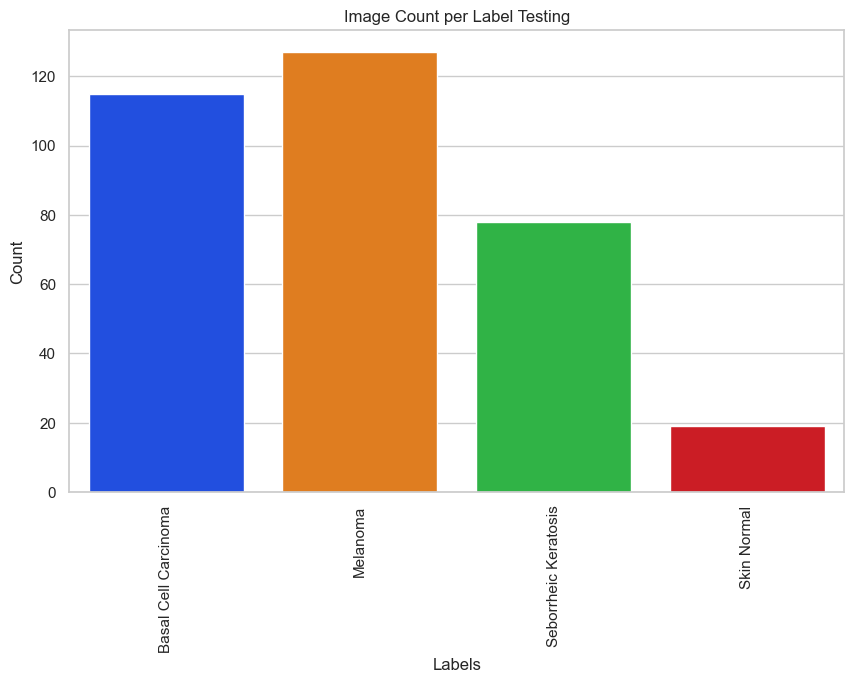

In [119]:
data_folder = 'datasets/Testing'


label_dirs = [d for d in os.listdir(data_folder) if os.path.isdir(os.path.join(data_folder, d))]


label_counts = {}
for label_dir in label_dirs:
    label_path = os.path.join(data_folder, label_dir)
    file_count = len([f for f in os.listdir(label_path) if os.path.isfile(os.path.join(label_path, f))])
    label_counts[label_dir] = file_count


sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()), palette="bright")

plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Image Count per Label Testing')
plt.xticks(rotation='vertical')
plt.show()



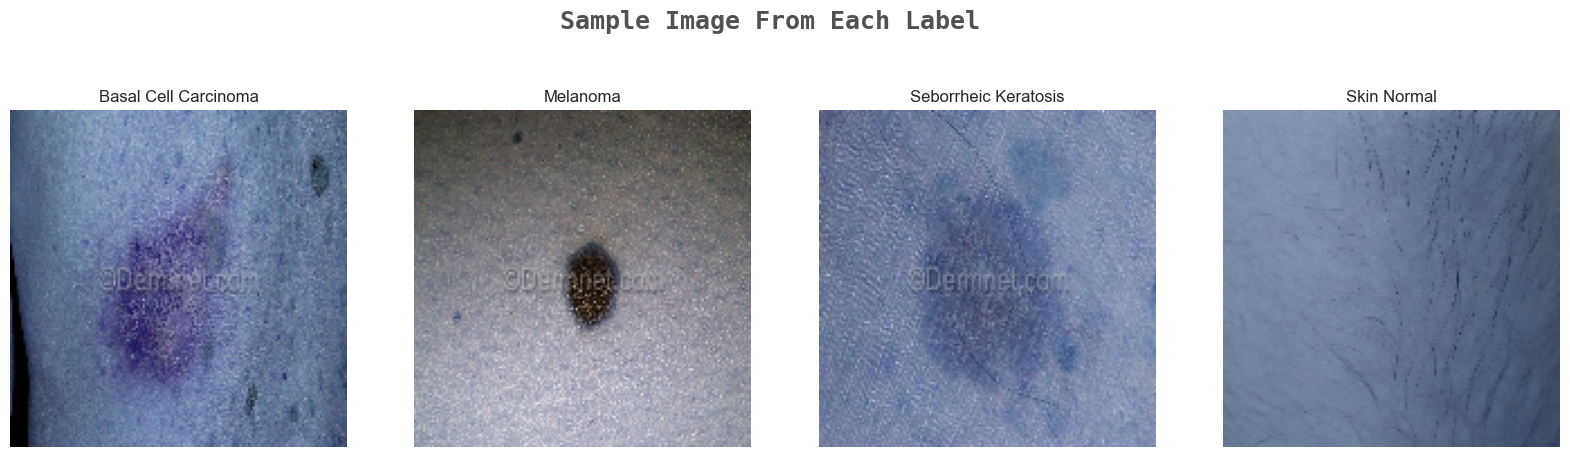

In [120]:
#mengolah data dengan menampilkan berdasarkan labelnya masing masing
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label' ,size=18, fontweight='bold',
         fontname='monospace',y=0.62,x=0.4,alpha=0.8)
for i in labels:
  j=0
  while True :
    if y_train[j]==i:
      ax[k].imshow(x_train[j])
      ax[k].set_title(y_train[j])
      ax[k].axis('off')
      k+=1
      break
    j+=1

In [121]:
#membuat data z_train dan y_train selalu diacak ketika di compile ulang
x_train, y_train = shuffle(x_train,y_train, random_state=101)

In [122]:
#melakukan variasi data dengan merubah rotasi gambar dll
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)

datagen.fit(x_train)

In [123]:
#Membagi data train menjadi 80% dan data testnya menjadi 20%
x_train,x_test,y_train,y_test = train_test_split(x_train,y_train, test_size=0.2, random_state=101)

In [124]:
#membagi categorical berdasarkan weightnya
y_train_new = []
for i in y_train:
  y_train_new.append(labels.index(i))
  y_train = y_train_new
  y_train = tf.keras.utils.to_categorical(y_train)

  y_test_new = []
for i in y_test:
  y_test_new.append(labels.index(i))
  y_test = y_test_new
  y_test = tf.keras.utils.to_categorical(y_test)

In [125]:
# weights='imagenet' digunakan mengimport bobot dari masing - masing gambar
#bobot dari proses sebelumnya akan digunakan untuk proses selanjutnya (transfer learning)
#agar mempersingkat waktu dalam proses klasifikasian
# menggunakan model EfficientNetB0 yang ada pada library keras
effnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

In [126]:
#pada layer nya kami mengambil GlobalPooling, Dropout, dll
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.2)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model) #pada dense itu ada 4 karena ada jenis kanker
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [127]:
#mengatur konfigurasi pelatihan model
model.compile(loss='categorical_crossentropy', optimizer = 'Adam', metrics= ['accuracy'])

In [128]:
#Digunakan untuk memantau dan memvisualisasikan metrik pelatihan dan pengujian model secara interaktif. 
tensorboard = TensorBoard(log_dir = 'logs')
#Digunakan untuk menyimpan model dengan performa terbaik selama pelatihan.
checkpoint = ModelCheckpoint("effenet.h5", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
#Digunakan untuk mengurangi laju pembelajaran (learning rate) jika tidak ada peningkatan yang signifikan dalam akurasi validasi. 
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001, mode='auto', verbose=1)

In [129]:
# melatih model dengan menggunakan data pelatihan (x_train dan y_train) menggunakan fungsi fit()
history = model.fit(x_train, y_train, validation_split=0.1, epochs=30, verbose=1, batch_size=32,
callbacks=[tensorboard, checkpoint, reduce_lr])

Epoch 1/30
30/30 [==============================] - ETA: 0s - loss: 0.6649 - accuracy: 0.7429
Epoch 1: val_accuracy improved from -inf to 0.78505, saving model to effenet.h5
30/30 [==============================] - 33s 375ms/step - loss: 0.6649 - accuracy: 0.7429 - val_loss: 0.6383 - val_accuracy: 0.7850 - lr: 0.0010
Epoch 2/30
30/30 [==============================] - ETA: 0s - loss: 0.2363 - accuracy: 0.9258
Epoch 2: val_accuracy did not improve from 0.78505
30/30 [==============================] - 7s 235ms/step - loss: 0.2363 - accuracy: 0.9258 - val_loss: 1.2100 - val_accuracy: 0.6636 - lr: 0.0010
Epoch 3/30
30/30 [==============================] - ETA: 0s - loss: 0.1128 - accuracy: 0.9645
Epoch 3: val_accuracy improved from 0.78505 to 0.85981, saving model to effenet.h5
30/30 [==============================] - 8s 265ms/step - loss: 0.1128 - accuracy: 0.9645 - val_loss: 0.6272 - val_accuracy: 0.8598 - lr: 0.0010
Epoch 4/30
30/30 [==============================] - ETA: 0s - loss: 0.0

In [130]:
#membuat kesimpulan dari hasil pelatihan
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_4 (Rescaling)        (None, 150, 150, 3)  0           ['input_5[0][0]']                
                                                                                                  
 normalization_4 (Normalization  (None, 150, 150, 3)  7          ['rescaling_4[0][0]']            
 )                                                                                                
                                                                                            

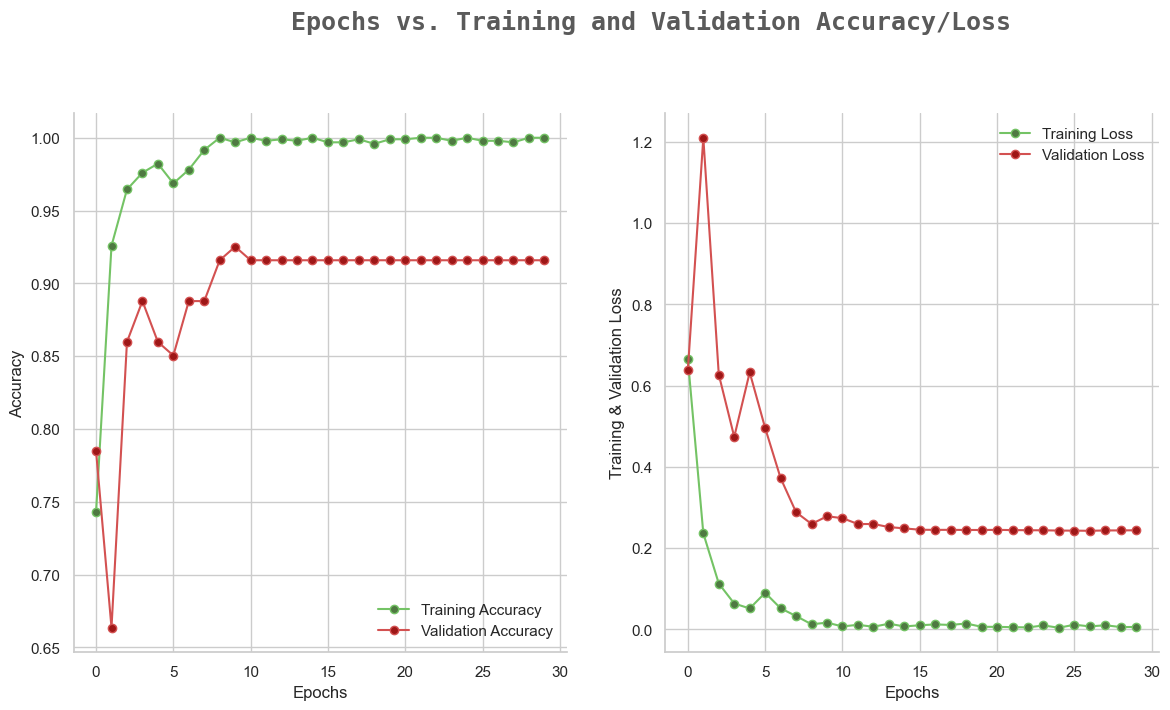

In [131]:
#Membuat grafik dari hasil pelatihan
filterwarnings('ignore')

epochs = [i for i in range(30)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold', fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3], label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3], label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3], label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [132]:
#model predict
pred = model.predict(x_test)
pred = np.argmax(pred, axis=1)
y_test_new = np.argmax(y_test, axis=1)

9/9 [==============================] - 4s 87ms/step


In [133]:
#evaluasi predict
print(classification_report(y_test_new, pred))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88        98
           1       0.88      0.93      0.91        73
           2       0.81      0.80      0.80        59
           3       1.00      1.00      1.00        36

    accuracy                           0.89       266
   macro avg       0.90      0.90      0.90       266
weighted avg       0.89      0.89      0.89       266



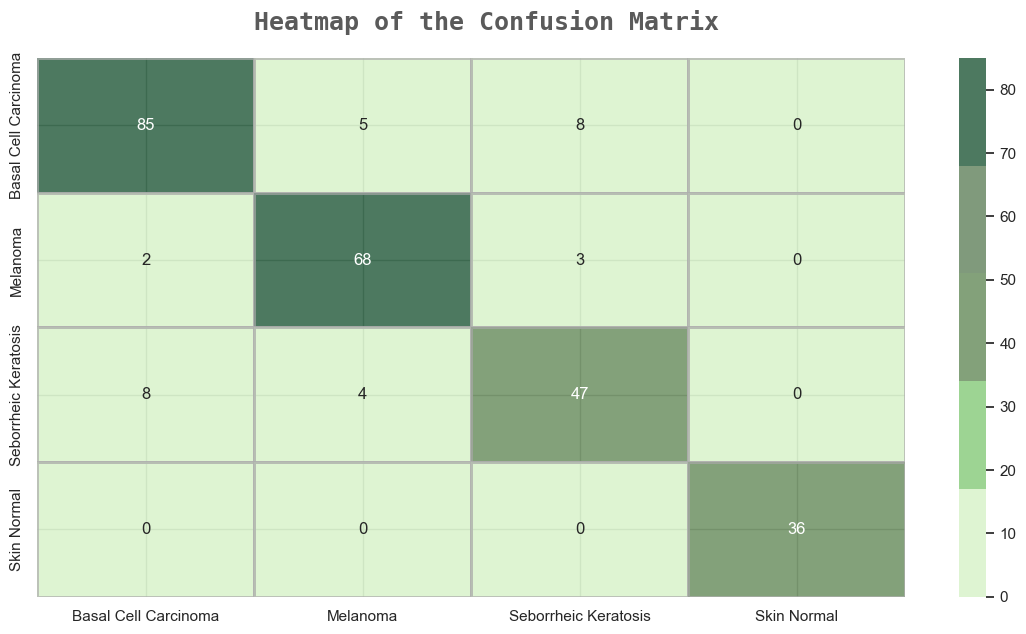

In [134]:
#Membuat confusion matrix
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new, pred), ax=ax, xticklabels=labels, yticklabels=labels, annot=True,
            cmap=colors_green[::-1], alpha=0.7, linewidths=2, linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix', size=18, fontweight='bold',
         fontname='monospace', color=colors_dark[1], y=0.92, x=0.28, alpha=0.8)

plt.show()

In [137]:
#Melakukan Percobaan Hasil Pelatihan
img = cv2.imread('Validasi/9.jpg')
opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
img = cv2.resize(img, (150,150))
img = img.reshape(1,150,150,3)
p = model.predict(img)
p = np.argmax(p, axis=1)[0]

if p==0:
    p='Basal Cell Carcinoma Cencer'
elif p==1:
    p='Melanoma Cencer'
elif p==2:
    p='Seborrheic Keratosis Cencer'
elif p==3:
    print('model predict tidak terdeteksi kanker')

if p!=3:
    print(f'model predict terdeteksi {p}')

1/1 [==============================] - 1s 1s/step
model predict terdeteksi Melanoma Cencer


In [ ]:
#Ekspor Model Pelatihan
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk
